### Import Libraries

In [95]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
import numpy as np
import edward as ed
import pandas as pd
from time import time
import tensorflow as tf
from edward.models import Categorical, Normal
from keras.utils import to_categorical

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample

### Sklearn related modules

In [97]:
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [98]:
random_seed = 2018

In [100]:
ed.set_seed(random_seed)

### Plot related setups

In [7]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
%matplotlib inline

plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [8]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [9]:
df = shuffle(df_train_all, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)

### Class Balance

In [10]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [11]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [12]:
df_minor.shape[0]

559

In [13]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = 2018)

In [14]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [15]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Fetaure Scaling

In [16]:
mms = StandardScaler()
train_scale = mms.fit(df_minor_upsmapled.drop('label', axis=1))

xtrain = train_scale.transform(df_minor_upsmapled.drop('label', axis=1))
ytrain =  np.array(df_minor_upsmapled['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [17]:
np.shape(xtrain)

(2082, 8)

### Model

In [18]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

In [19]:
def neural_network(X, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    output = tf.nn.sigmoid(tf.matmul(hidden1, W_1) + b_1)
    return output

### Model Prior beliefs

In [20]:
with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)   

### Model posterior weights

In [21]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale = tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale = tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale = tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale = tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

### Inference

In [22]:
with tf.name_scope("inference"):
    
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                         W_1: qW_1, b_1: qb_1}, 
                        data={X: xtrain, 
                              y: ytrain})

    global_step = tf.Variable(0, trainable=False, name = "global_step")
    initial_learning_rate = tf.Variable(0.05, trainable = False, name = "initial_learning_rate")

    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               10000, 0.3, staircase=True)

    optimizer = tf.train.AdamOptimizer(learning_rate)

    inference.run(n_iter = 1000, optimizer = optimizer, global_step = global_step, logdir = r'./log')

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 2207.314


### Sampling 

In [36]:
n_samples = 500

qW_0_samples = qW_0.sample(sample_shape=n_samples)
qW_1_samples = qW_1.sample(sample_shape=n_samples)
qb_0_samples = qb_0.sample(sample_shape=n_samples)
qb_1_samples = qb_1.sample(sample_shape=n_samples)

print("Preparing to sample...")

t0 = time()
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

print("Took", np.int(time() - t0), "secs.")

print("Sampling...")
t0 = time()
samplepredictions = samplenodes.eval(feed_dict={X: xtest})
print("Took", np.int(time() - t0), "secs.")
predictions_samp = samplepredictions[:, :, 0]

Preparing to sample...
Took 7 secs.
Sampling...
Took 2 secs.


### Prior and posterior weight vizualization

In [128]:
### prior weights
prior_weights = W_0.eval(), W_1.eval(), b_0.eval(), b_1.eval()

### Posterior mean weights
post_weights = qW_0_samples.eval().mean(axis = 0), qW_1_samples.eval().mean(axis = 0),\
               qb_0_samples.eval().mean(axis = 0), qb_1_samples.eval().mean(axis = 0)

### Posterior weights of a NN that maximizes the accuracies


In [134]:
def plot_weight_distribution(prior = True):

    plt.figure(figsize=(8, 6))
    
    wgt = ['w0', 'w1', 'b0', 'b1']
    lbl = ['a', 'b', 'c', 'd']
    
    for i in range(len(prior_weights)):
        plt.subplot(2, 2, i+1)
        if i == 3:
            plt.plot(prior_weights[i].reshape(-1), "ro", label = 'Prior')
            plt.plot(post_weights[i].reshape(-1), "bo", label = 'Prior')
        else:
            sns.kdeplot(prior_weights[i].reshape(-1), shade = True, color = "r", label = 'Prior')
            sns.kdeplot(post_weights[i].reshape(-1), shade = True, color = "b", label = 'Posterior')

        plt.title('(' + lbl[i] + ') ' + wgt[i])
        plt.ylabel('PDF')
        
    plt.legend()
    plt.tight_layout()
    plt.show()

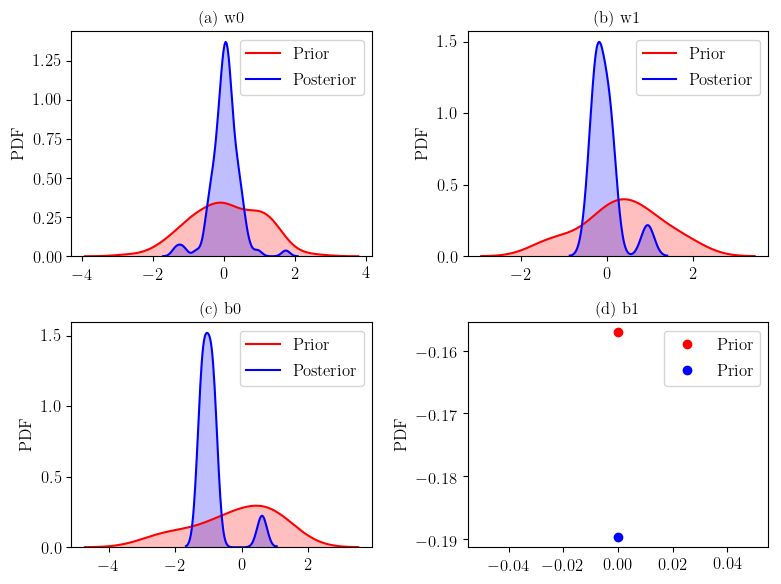

In [135]:
plot_weight_distribution()

In [69]:
results = pd.DataFrame()
results['target'] = list(ytest)
results.target = results.target.apply(lambda x: int(x[0]))

In [70]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['pred_std'] = predictions_samp.std(axis = 0)
results['pred_var'] = predictions_samp.var(axis = 0)

In [71]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['pred_std'])
results['confidence_low'] = np.transpose(zzz)[:, 0]
results['confidence_high'] = np.transpose(zzz)[:, 1]
results['confidence_range'] = np.absolute(results['confidence_high'] - results['confidence_low'])

In [72]:
results['bin_pred'] = results.predictions.apply(lambda x: 1 if x >= 0.5 else 0)

In [73]:
def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [74]:
prediction(ytest, results['bin_pred'])

Accuracy of the model: 0.79

Classification report: 
             precision    recall  f1-score   support

        0.0       0.91      0.76      0.83       272
        1.0       0.63      0.84      0.72       128

avg / total       0.82      0.79      0.80       400


Confusion matrix: 
[[208  64]
 [ 20 108]]



### Prediction on the 

In [75]:
all_samples = pd.DataFrame(predictions_samp).applymap(lambda x: 1 if x >= 0.5 else 0)

In [76]:
accuracies = []
for i in range(n_samples):
    ypred = all_samples.iloc[i]
    accuracies.append(accuracy_score(ytest, ypred))

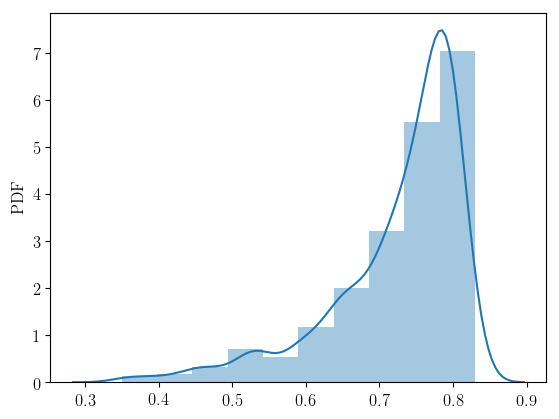

In [77]:
sns.distplot(accuracies, kde = True, bins = 10)
plt.ylabel('PDF')
plt.show()

In [83]:
print(np.std(accuracies)*2, np.mean(accuracies), np.max(accuracies))

0.17924427020130937 0.72473 0.83


### Error analysis

In [131]:
correct = results[(results.target == results.bin_pred)]

In [132]:
incorrect = results[(results.target != results.bin_pred)]

In [133]:
correct.columns

Index(['target', 'predictions', 'pred_std', 'pred_var', 'confidence_low',
       'confidence_high', 'confidence_range', 'bin_pred'],
      dtype='object')

In [134]:
incorrect.confidence_range[(incorrect.bin_pred == 0)].mean(axis = 0)

0.7069156764028911

In [135]:
correct.confidence_range[(correct.bin_pred == 0)].mean(axis = 0)

0.7492029186865446

In [129]:
sns.set(color_codes=True)

def plot_distribution(i):
    xxx = samplepredictions[:, i, 0]
    ax = sns.distplot(xxx, kde=False, fit=stats.gamma)
    ax2 = ax.twinx()
    sns.boxplot(x=xxx, ax=ax2)
    ax2.set(ylim=(-.5, 10))
    plt.show()

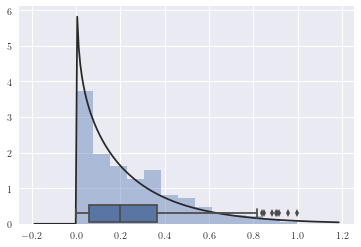

In [130]:
plot_distribution(66)

### Result vizualisation

In [66]:
pca = PCA(n_components = 2, random_state = 2018).fit_transform(xtest)

results['pca_x1'] = pca[:, 0]
results['pca_x2'] = pca[:, 1]

In [120]:
results.head()

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred,pca_x1,pca_x2
0,0.0,0.247330,0.098857,0.009773,0.149021,0.345639,0.196618,0,0.557490,-1.138433
1,1.0,0.943311,0.043379,0.001882,0.900172,0.986450,0.086278,1,0.372588,2.210410
2,0.0,0.218576,0.132310,0.017506,0.086999,0.350153,0.263154,0,-2.883425,-0.418066
3,0.0,0.274191,0.124581,0.015520,0.150300,0.398081,0.247781,0,0.412756,-1.462043
4,1.0,0.569014,0.199379,0.039752,0.370741,0.767288,0.396547,1,2.860224,0.236508


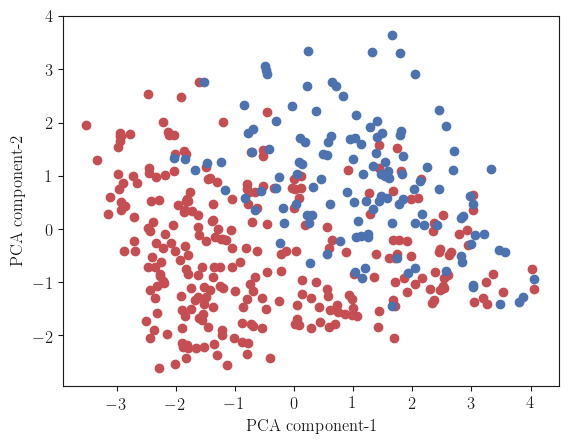

In [124]:
plt.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
plt.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

plt.xlabel('PCA component-1')
plt.ylabel('PCA component-2')
plt.show()

In [231]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [233]:
print(np.shape(grid), np.shape(grid_2d), np.shape(dummy_out))

(2, 100, 100) (10000, 2) (100,)


In [228]:
from matplotlib.mlab import griddata

xi = np.linspace(-4, 4, 100)
yi = np.linspace(-4, 4, 100)

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean uncertainity')

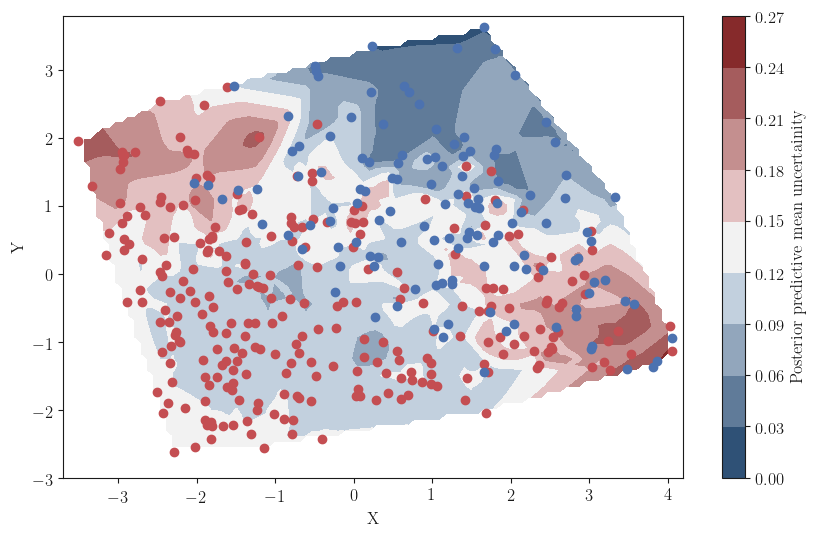

In [230]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.pred_std, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean uncertainity')

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean probability')

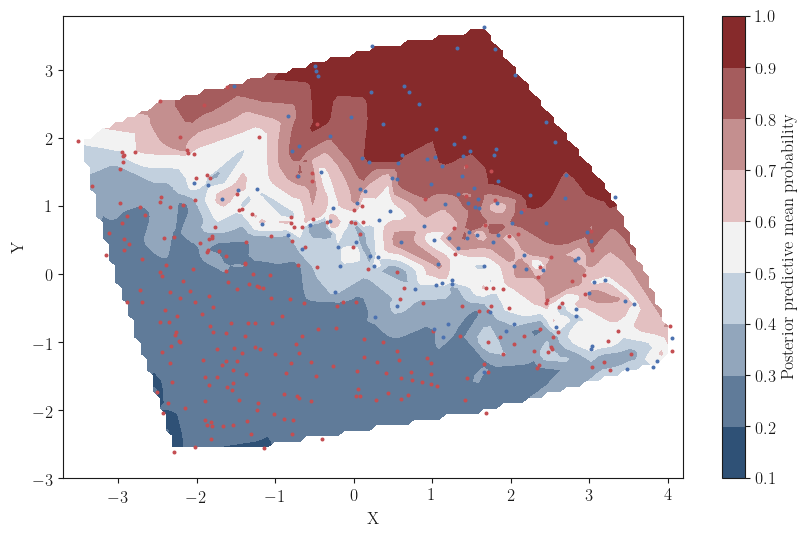

In [177]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.predictions, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 3.5)
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b', s = 3.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean probability')

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean probability')

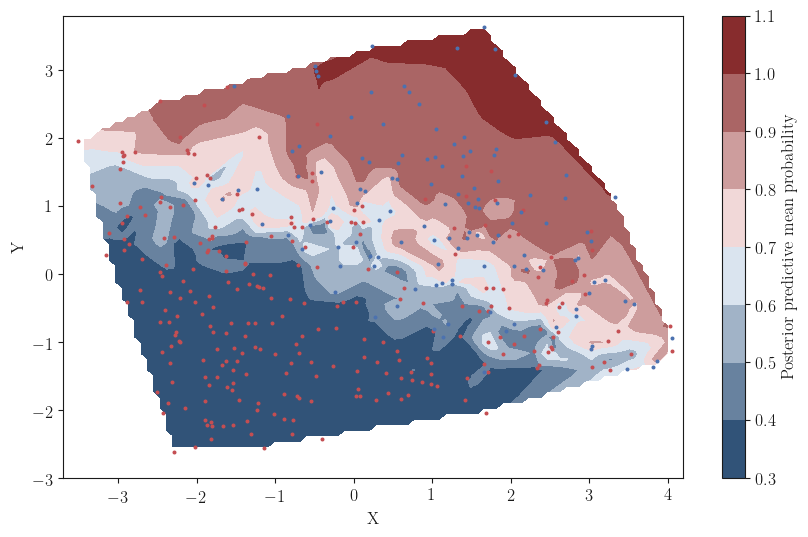

In [182]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.confidence_high, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 3.5)
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b', s = 3.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean probability')

AttributeError: 'Series' object has no attribute 'reshape'

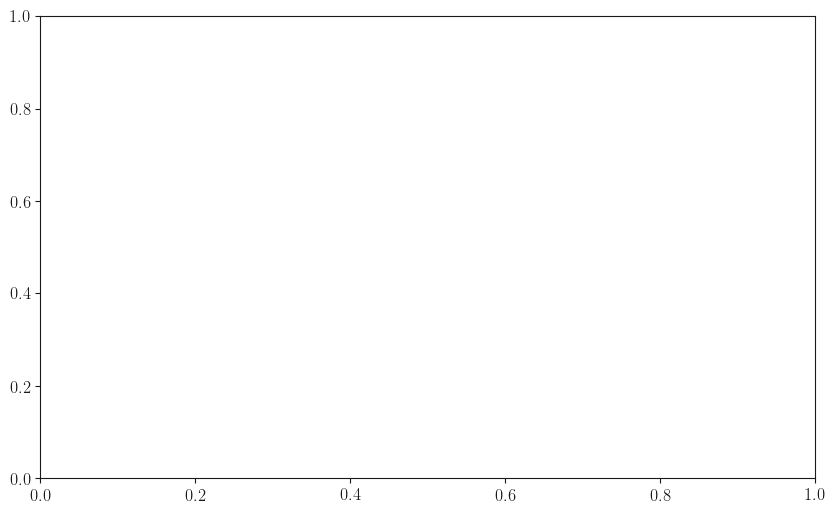

In [103]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(*grid, results.predictions.reshape(100, 100), cmap=cmap)

# ax.scatter(xtest[pred==0, 0], xtest[pred==0, 1])
# ax.scatter(Xtest[pred==1, 0], xtest[pred==1, 1], color='r')

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### CRITICISM

In [ ]:
x_post = ed.copy(x, {p: qp})

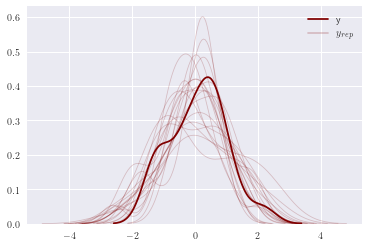

In [191]:
import matplotlib.pyplot as plt

y = np.random.randn(20)
y_rep = np.random.randn(20, 20)

ed.ppc_density_plot(y, y_rep)
plt.show()